## Libs

In [1]:
import IPython
%load_ext autoreload

%autoreload 2

In [2]:
from addict import Dict
import albumentations as A
from albumentations.pytorch import ToTensorV2

import logging

from matplotlib import pyplot
import numpy as np
import os
import os.path as osp
import pandas as pd
from pprint import pprint
from PIL import Image
import sys
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from typing import Union, Any, List

# Logger config
logging.basicConfig(level="INFO")

In [3]:
# all scripts are ment to be run from the AEJEPS folder

%cd ..
sys.path.append("src/")


/home/zeusdric/jepsam/repo/AEJEPS


In [4]:
os.getcwd()

'/home/zeusdric/jepsam/repo/AEJEPS'

In [5]:
from utils.parser import parse_args, load_config

import vocabulary as vocab

## Config

In [6]:
cfg = load_config(config_file_path="configs/aejeps_cfg.yaml")

In [7]:
cfg.AEJEPS

{'EMBEDDING_DIM': 256,
 'HIDDEN_DIM': 256,
 'CNN_FC_DIM': 256,
 'NUM_LAYERS_ENCODER': 2,
 'BATCH_FIRST': True,
 'ENCODER_DROPOUT': 0.35,
 'IS_BIDIRECTIONAL': True,
 'NUM_LAYERS_MOTOR': 1,
 'ACTIVATION_MOTOR': 'LeakyReLU',
 'MOTOR_DROPOUT': 0.25,
 'NUM_LAYERS_LANG': 2,
 'ACTIVATION_LANG': 'LeakyReLU',
 'LANG_DROPOUT': 0.25,
 'HIDDEN_TO_CONV': 1024,
 'DECODER_ACTIVATION': 'Sigmoid'}

In [8]:
cfg.DATASET.PATH

'../dataset/'

### Load curated dataset

In [9]:
tdf = pd.read_csv(
    osp.join(cfg.DATASET.PATH, "updated_train.csv")
)

tdf.head()

,sample_ID,in_state,goal_state,validator,action_description,motor_cmd,len_action_desc,len_motor_cmd
0,1005,0,9,amihretu,put the :BOTTLE to the left of :BOTTLE,:BOTTLE BLUE POSE-9 :BOTTLE RED POSE-2 :BOTTLE...,38,84
1,1011,0,9,amihretu,move the :BOTTLE left,:BOTTLE BLUE POSE-3 :BOTTLE #'*leftward-trans...,21,65
2,1012,0,9,amihretu,put the :BOTTLE to the right of :MUG,:BOTTLE BLUE POSE-7 :MUG RED POSE-3 :BOTTLE #...,36,79
3,1013,0,9,amihretu,shift the :CUP backwards,:CUP RED POSE-4 :CUP #'*backward-transformati...,24,55
4,1015,0,9,amihretu,shift the :BOTTLE forwards,:BOTTLE GREEN POSE-3 :BOTTLE #'*forward-trans...,26,65


### Dataset utils

In [10]:
class SimpleTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def tokenize_by_space(
        self, 
        full_string:str
    )->list:
        return full_string.split()


    def idx2token(
        self, 
        i:int
    )->str:
        return self.vocab.REVERSE_TOKENS_MAPPING[i]

    def token2idx(
        self, 
        t:str
    )->int:
        return self.vocab.TOKENS_MAPPING[t]

    def encode(self, input:str):
        tokens = self.tokenize_by_space(input)
        tokens = [self.vocab.SPECIAL_TOKENS[0]] + tokens + [self.vocab.SPECIAL_TOKENS[-1]]
        token_ids = torch.tensor([self.token2idx(t) for t in tokens])
        # enc = {
        #     "tokens": tokens,
        #     "input_ids": torch.tensor(token_ids)
        # }
        return token_ids
    
    def batch_encode(self, input:Union[List, np.ndarray]):
        batch_size = len(input)
        batch_token_ids = [self.encode(inp) for inp in input]
        return batch_token_ids
    
    def decode(self, token_ids:torch.tensor)->list:
        tokens = [self.idx2token(i) for i in token_ids.tolist()]
        return tokens
    
    def batch_decode(self, input:Union[List, np.ndarray]):

        batch_size = len(input)

        batch_tokens = [self.decode(inp) for inp in input]

        return batch_tokens
    
tokenizer = SimpleTokenizer(vocab)

In [11]:
ex = tdf.sample(n=10)

ex["action_description"].values.tolist(), len(ex)

(['put the :BOWL to the right of :BOTTLE',
  'put the :BOTTLE to the left of :MONDAMIN',
  'shift the :CEREAL left',
  'put the :BOWL to the left of :SPATULA',
  'put the :CUP to the right of :BUTTERMILK',
  'put the :CUP in front of :CUP',
  'put the :CEREAL to the right of :SPATULA',
  'shift the :CEREAL left',
  'put the :CEREAL behind :BUTTERMILK',
  'put the :CEREAL in front of :PLATE'],
 10)

In [12]:
e = tokenizer.batch_encode(ex["action_description"].values.tolist())
e

[tensor([48, 59, 62,  6, 63, 62, 60, 57,  5, 46]),
 tensor([48, 59, 62,  5, 63, 62, 55, 57, 18, 46]),
 tensor([48, 61, 62, 10, 55, 46]),
 tensor([48, 59, 62,  6, 63, 62, 55, 57, 24, 46]),
 tensor([48, 59, 62, 12, 63, 62, 60, 57,  8, 46]),
 tensor([48, 59, 62, 12, 54, 53, 57, 12, 46]),
 tensor([48, 59, 62, 10, 63, 62, 60, 57, 24, 46]),
 tensor([48, 61, 62, 10, 55, 46]),
 tensor([48, 59, 62, 10, 51,  8, 46]),
 tensor([48, 59, 62, 10, 54, 53, 57, 20, 46])]

In [13]:
tokenizer.batch_decode(e)

[['[SOS]',
  'put',
  'the',
  ':BOWL',
  'to',
  'the',
  'right',
  'of',
  ':BOTTLE',
  '[EOS]'],
 ['[SOS]',
  'put',
  'the',
  ':BOTTLE',
  'to',
  'the',
  'left',
  'of',
  ':MONDAMIN',
  '[EOS]'],
 ['[SOS]', 'shift', 'the', ':CEREAL', 'left', '[EOS]'],
 ['[SOS]',
  'put',
  'the',
  ':BOWL',
  'to',
  'the',
  'left',
  'of',
  ':SPATULA',
  '[EOS]'],
 ['[SOS]',
  'put',
  'the',
  ':CUP',
  'to',
  'the',
  'right',
  'of',
  ':BUTTERMILK',
  '[EOS]'],
 ['[SOS]', 'put', 'the', ':CUP', 'in', 'front', 'of', ':CUP', '[EOS]'],
 ['[SOS]',
  'put',
  'the',
  ':CEREAL',
  'to',
  'the',
  'right',
  'of',
  ':SPATULA',
  '[EOS]'],
 ['[SOS]', 'shift', 'the', ':CEREAL', 'left', '[EOS]'],
 ['[SOS]', 'put', 'the', ':CEREAL', 'behind', ':BUTTERMILK', '[EOS]'],
 ['[SOS]', 'put', 'the', ':CEREAL', 'in', 'front', 'of', ':PLATE', '[EOS]']]

### Simple JEPSAM dataset

In [14]:
class SimpleJEPSAMDataset(Dataset):
    def __init__(
        self,
        cfg:Dict,
        vocab=vocab,
        csv:str = None,
        df: pd.DataFrame = None,
        apply_transforms: bool = True,
        task: str = "train"    
    ):
        super().__init__()

        self.vocab = vocab
        self.dataset_directory = osp.join(cfg.DATASET.PATH, "JEPS_data")
        self.tokenizer = SimpleTokenizer(vocab)
        self.cfg = cfg
        
        if df is not None:
            self.dataset_points = df.copy()
        else:
            self.dataset_points = pd.read_csv(csv)
        
        # image transforms
        self.apply_transforms = apply_transforms
        if task == "train":
            tfms = [
                getattr(A, tfms)(**params) for tfms, params in self.cfg.DATASET.TRAIN_TFMS.items()
            ]
        else:
            tfms = [
                getattr(A, tfms)(**params) for tfms, params in self.cfg.DATASET.TEST_TFMS.items()
            ]

        tfms.append(A.Normalize())
        tfms.append(ToTensorV2())
        self.transforms = A.Compose(tfms) if self.apply_transforms else None

    def __len__(self):
        return len(self.dataset_points)

    def __getitem__(self, idx):
        
        data_point = self.dataset_points.iloc[idx]
        
        # visual inputs
        ## in state
        in_state = np.array(Image.open(os.path.join(
            self.dataset_directory, str(data_point.sample_ID), str(data_point.in_state)
        )))

        goal_state = np.array(Image.open(os.path.join(
            self.dataset_directory, str(data_point.sample_ID), str(data_point.goal_state)
        )))
        # apply image treansforms
        if self.apply_transforms:
            # apply transforms
            in_state = self.transforms(image=in_state)["image"]
            goal_state = self.transforms(image=goal_state)["image"]        
        
        # Language modalities
        ## action desc
        action_description = self.tokenizer.encode(input=data_point.action_description)

        ## motor cmd
        motor_command = self.tokenizer.encode(input=data_point.motor_cmd)
        
        
        sample = {
            "sample_id": data_point.sample_ID,
            "in_state": in_state,
            "goal_state": goal_state,
            "action_desc": {
                "raw"   : data_point.action_description,
                "ids"   : action_description.long(),
                "length": data_point.len_action_desc
            },
            "motor_cmd": {
                "raw"   : data_point.motor_cmd,
                "ids"   : motor_command.long(),
                "length": data_point.len_motor_cmd
            }
        }

        return sample

    def collate_fn(self, batch):
        
        # imgs
        batch_input_state = [b["in_state"] for b in batch]
        batch_input_state_stack = torch.stack(batch_input_state)
        
        batch_goal_state = [b["goal_state"] for b in batch]
        batch_goal_state_stack = torch.stack(batch_goal_state)

        # ad
        batch_action_desc = [b["action_desc"]["ids"] for b in batch]
        # print(batch_action_desc)
        batch_action_description = pad_sequence(
            batch_action_desc, 
            batch_first=True, 
            padding_value=self.vocab.TOKENS_MAPPING["[PAD]"]
        )
        # print(batch_action_description)
        
        batch_action_desc_lens = torch.as_tensor([b["action_desc"]["length"] for b in batch])
        # batch_action_desc_lens_stack = torch.tensor(batch_action_desc_lens)
        # print(batch_action_desc_lens_stack)
        
        #cmd
        batch_motor_commands = [b["motor_cmd"]["ids"] for b in batch]
        batch_motor_commands = pad_sequence(
            batch_motor_commands, 
            batch_first=True, 
            padding_value=self.vocab.TOKENS_MAPPING["[PAD]"]
        )
        batch_motor_commands_lens = torch.as_tensor([b["motor_cmd"]["length"] for b in batch])
        
        out = (
            batch_input_state_stack, 
            batch_goal_state_stack, 
            batch_action_description, 
            batch_motor_commands, 
            batch_action_desc_lens, 
            batch_motor_commands_lens
        )
        return out
                

#### Test dataset

In [15]:
ds = SimpleJEPSAMDataset(
    df=tdf,
    cfg=cfg
)

len(ds)

1972

In [16]:
rand_idx = np.random.randint(low=0, high=len(ds))
ex = ds[rand_idx]

print("Dataset size: ", len(ds))
print("="*100)
print("ID\t: ", ex["sample_id"])
print(">> InState\t: ", ex["in_state"].shape)
print(">> GoalState\t: ", ex["goal_state"].shape)
print(">> Desc\t:")
pprint(ex["action_desc"])
print(">> Cmd\t:")
pprint(ex["motor_cmd"])
print("="*100)

Dataset size:  1972
ID	:  3660
>> InState	:  torch.Size([3, 224, 224])
>> GoalState	:  torch.Size([3, 224, 224])
>> Desc	:
{'ids': tensor([48, 59, 62,  6, 51, 18, 46]),
 'length': 30,
 'raw': 'put the :BOWL behind :MONDAMIN'}
>> Cmd	:
{'ids': tensor([48,  6, 27, 34, 18, 28, 31,  6,  0, 18, 46]),
 'length': 88,
 'raw': ':BOWL BLUE POSE-13 :MONDAMIN GREEN POSE-10 :BOWL  '
        "#'*backward-transformation*  :MONDAMIN"}


In [17]:
ex["action_desc"]['ids'].shape

torch.Size([7])

#### Data Viz

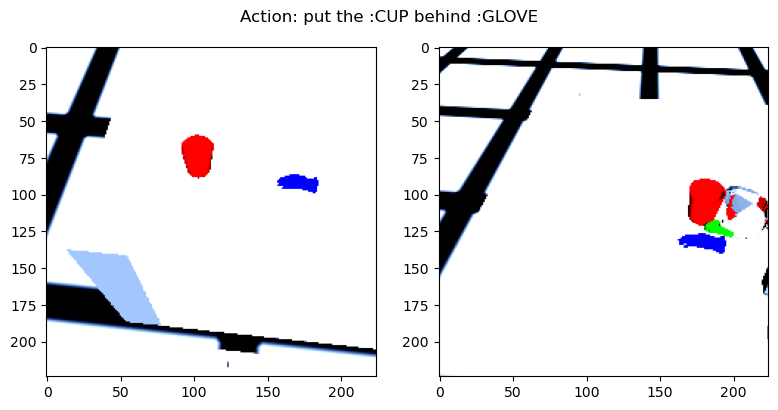

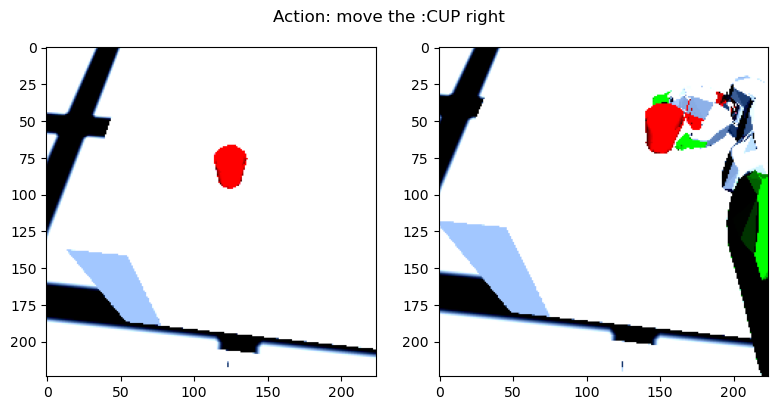

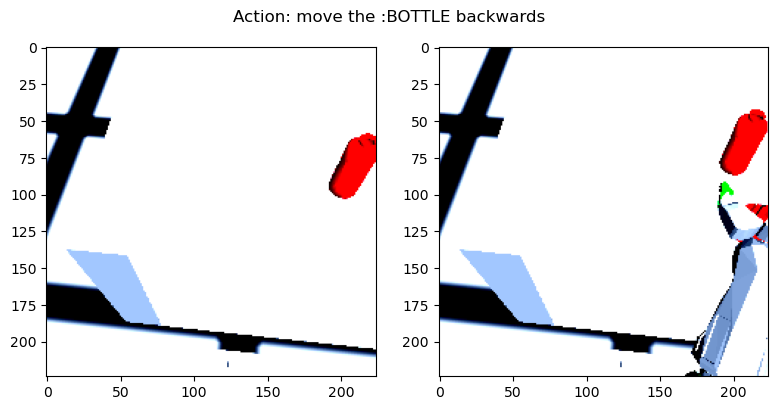

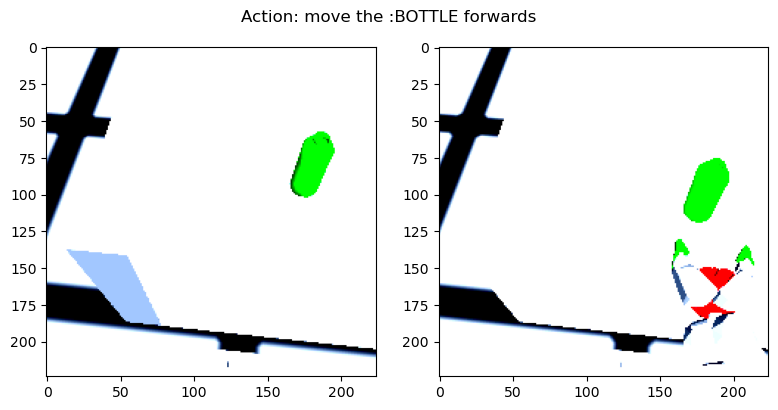

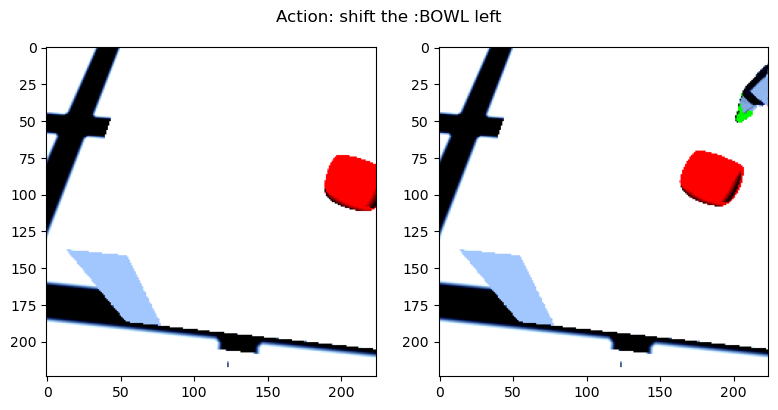

In [18]:
for _ in range(5):
    rand_idx = np.random.randint(low=0, high=len(ds))
    ex = ds[rand_idx]

    fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(8, 4))

    ax[0].imshow(ex["in_state"].permute(1, 2, 0))
    ax[1].imshow(ex["goal_state"].permute(1, 2, 0))

    desc = ex["action_desc"]["raw"]
    fig.suptitle(f"Action: {desc}")

    pyplot.tight_layout()
    pyplot.show()

### Data loaders

In [19]:
def get_dataloaders(cfg, train_df: pd.DataFrame, val_df: pd.DataFrame = None) -> tuple:

    csv_path = osp.join(cfg.DATASET.PATH, "updated_train.csv")
    dataset_path = osp.join(cfg.DATASET.PATH, "JEPS_data")

    val_pct = cfg.DATASET.VALIDATION_PCT

    if val_df is None:
        # 80/20 train/test split
        random_indices = np.random.rand(len(train_df)) < (1-val_pct)

        # Split the DataFrame into train and test sets
        train = train_df[random_indices].reset_index(drop=True)
        val = train_df[~random_indices].reset_index(drop=True)

    # datasets
    train_ds = SimpleJEPSAMDataset(
        df=train,
        cfg=cfg
    )
    val_ds = SimpleJEPSAMDataset(
        df=val,
        cfg=cfg
    )

    logging.info(
        f"Prepared {len(train_ds)} training samples and {len(val_ds)} validation samples ")

    # rand_idx = np.random.randint(low=0, high=len(train_ds))
    # ex = train_ds[rand_idx]

    # print("Dataset size: ", len(train_ds))
    # print("="*100)
    # print(">> ID\t: ", rand_idx)
    # print(">> InState\t: ", ex[0].shape)
    # print(">> GoalState\t: ", ex[1].shape)
    # print(">> Desc\t:")
    # pprint(ex[2])
    # print(">> Cmd\t:")
    # pprint(ex[3])
    # print("="*100)

    # data loaders
    train_dl = DataLoader(
        dataset=train_ds,
        batch_size=cfg.TRAIN.BATCH_SIZE,
        shuffle=True,
        num_workers=cfg.TRAIN.NUM_WORKERS,
        pin_memory=True,
        collate_fn=train_ds.collate_fn
    )

    val_dl = DataLoader(
        dataset=val_ds,
        batch_size=cfg.TRAIN.BATCH_SIZE,
        shuffle=False,
        num_workers=cfg.TRAIN.NUM_WORKERS,
        pin_memory=True,
        collate_fn=val_ds.collate_fn

    )

    return (train_dl, val_dl)

### test DL

In [20]:
train_dl, val_dl = get_dataloaders(
    cfg=cfg,
    train_df = tdf
)

INFO:root:Prepared 1508 training samples and 464 validation samples 


In [21]:
logging.info("\n>> train data loader")
print(f"# train batches\t: {len(train_dl)}")
for data in train_dl:
    in_state, goal_state, ad, cmd, ad_lens, cmd_lens = data[0], data[1], data[2], data[3], data[4], data[5]
    print("In\t\t:", in_state.shape)
    print("Goal\t\t:", goal_state.shape)
    print("Action desc\t:", ad.shape)
    print("Action desc (len)\t:", ad_lens.shape)
    print("CMD\t\t:", cmd.shape)
    print("CMD(len)\t\t:", cmd_lens.shape)
    break

logging.info("\n\n>> val data loader")
print(f"# validation batches\t: {len(val_dl)}")
for data in val_dl:
    in_state, goal_state, ad, cmd, ad_lens, cmd_lens = data[0], data[1], data[2], data[3], data[4], data[5]
    print("In\t\t:", in_state.shape)
    print("Goal\t\t:", goal_state.shape)
    print("Action desc\t:", ad.shape)
    print("CMD\t\t:", cmd.shape)
    print("CMD(len)\t\t:", cmd_lens.shape)
    break

INFO:root:
>> train data loader


# train batches	: 189
In		: torch.Size([8, 3, 224, 224])
Goal		: torch.Size([8, 3, 224, 224])
Action desc	: torch.Size([8, 10])
Action desc (len)	: torch.Size([8])
CMD		: torch.Size([8, 11])
CMD(len)		: torch.Size([8])


INFO:root:

>> val data loader


# validation batches	: 58
In		: torch.Size([8, 3, 224, 224])
Goal		: torch.Size([8, 3, 224, 224])
Action desc	: torch.Size([8, 10])
CMD		: torch.Size([8, 11])
CMD(len)		: torch.Size([8])
